In [10]:
import torch as pt


mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_all = pt.load('./data/mine/mols_all.pt')
print(len(mols_all))

11499
2253216


In [11]:
# 统计词频
import numpy as np


mols_train = mols_all[:232826]
count_list = np.zeros(1000)
for mol in mols_train:
    tmp_list = np.zeros(1000)
    for mz in mol.mz:
        tmp_list[int(mz)] = 1
    count_list += tmp_list

count_list += 1  
print(count_list.shape)

(1000,)


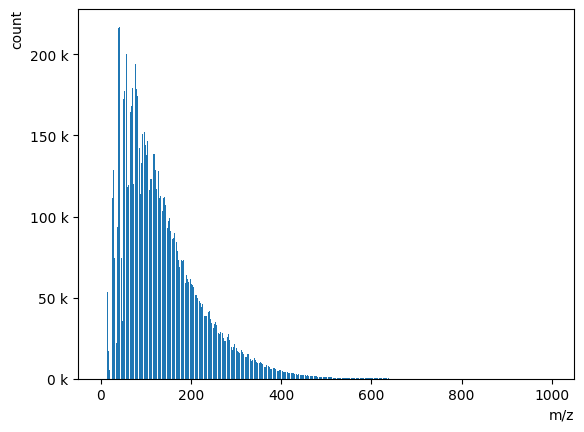

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig = plt.figure()
ax = fig.add_subplot()
ax.bar(np.arange(1000), count_list)
ax.set_xlabel('m/z', loc='right')
ax.set_ylabel('count', loc='top')
# ax.legend()
def formatter(x, pos):
    return f'{int(x/1000)} k'
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatter))
# fig.savefig('count_bar.svg', format='svg', dpi=500)

In [12]:
import numpy as np


# 生成负采样概率
pow_frequency = np.array(count_list) ** 0.75
neg_prob = pow_frequency / pow_frequency.sum()
print(neg_prob.shape)
# 生成下采样概率
mzs_freq = np.array(count_list)
mzs_freq = mzs_freq / np.sum(mzs_freq)
t = 1e-3
keep_prob = np.array([np.sqrt(t/f) + t/f for f in mzs_freq])

(1000,)


In [14]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun, collate_fun_emb
import numpy as np


dataset_lib = SpecDataset(mols_all)
dataset_test = SpecDataset(mols_test)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_train = SpecDataset(dataset_lib, mapping=np.arange(232826))
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, 
                            num_workers=8, collate_fn=collate_fun(keep_prob, neg_prob))
num_batches = len(loader_train)

In [ ]:
import torch.optim as optim
from utils.model import Spec2Emb, Linear_Scheduler


gpu = 6
model = Spec2Emb().to(gpu)

epochs = 10
lr = 0.025
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = Linear_Scheduler(optimizer, epochs, start_lr=lr, end_lr=2.5e-4)

In [16]:
from tqdm import tqdm
from utils.tools import gen_embeddings, build_idx, evaluate, save_model



f = open('base.txt', 'w')
model_name = 'base'
max_metrics = {'expand': [0, 0], 'insilico': [0, 0]}
for epoch in range(epochs):
    print(f'==================================Train_epoch{epoch+1}======================================')
    model.train()
    train_loss = []
    for i, Data in enumerate(tqdm(loader_train, unit='batch')):
        data = [d.to(gpu) for d in Data]
        optimizer.zero_grad()
        loss = model(data)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        batch_progress = (i+1)/num_batches
        lr = scheduler.lr_lambda(epoch, batch_progress)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        if (i+1) %1000 ==0:
            loss = np.mean(train_loss)
            print(f'Total Loss: {loss}')
            train_loss = []
    
    print(f'===================================Test_epoch{epoch+1}======================================')
    f.write('\nTest_epoch%d\n' % (epoch+1))
    embeddings_lib = gen_embeddings(model, loader_lib, gpu)
    embeddings_test = gen_embeddings(model, loader_test, gpu)
    I_expand, _ = build_idx(embeddings_lib, embeddings_test, gpu)
    top1_expand, top10_expand = evaluate(mols_test, I_expand, mols_all, f, 'Expanded')
    if top1_expand > max_metrics['expand'][0] and top10_expand > max_metrics['expand'][1]:
        max_metrics['expand'] = [top1_expand, top10_expand]
        save_model(model, model_name, epoch)
    I_insilico, _ = build_idx(embeddings_lib[:2146690], embeddings_test, gpu)
    top1_insilico, top10_insilico = evaluate(mols_test, I_insilico, mols_all, f, 'In-silico')
    if top1_insilico > max_metrics['insilico'][0] and top10_insilico > max_metrics['insilico'][1]:
        max_metrics['insilico'] = [top1_insilico, top10_insilico]
        save_model(model, model_name, epoch)
    print(f'================================================================================================')
f.close()

==================================Train_epoch1======================================


 14%|█▍        | 1008/7276 [00:22<01:58, 52.79batch/s]

Total Loss: 6033.385208251953


 28%|██▊       | 2010/7276 [00:41<01:39, 53.03batch/s]

Total Loss: 5150.754780517578


 41%|████▏     | 3010/7276 [00:59<01:15, 56.17batch/s]

Total Loss: 4929.621965820313


 55%|█████▌    | 4007/7276 [01:17<01:04, 50.89batch/s]

Total Loss: 4828.038224853515


 69%|██████▉   | 5010/7276 [01:36<00:42, 53.90batch/s]

Total Loss: 4770.24563671875


 83%|████████▎ | 6008/7276 [01:54<00:23, 54.67batch/s]

Total Loss: 4714.367713134766


 96%|█████████▋| 7008/7276 [02:12<00:05, 50.64batch/s]

Total Loss: 4710.030742431641


100%|██████████| 7276/7276 [02:18<00:00, 52.49batch/s]

===================================Test_epoch1======================================


Searching time:  0:00:01.567816
Expanded library
Top1 hit rate: 38.98%
Top10 hit rate: 80.24%
Searching time:  0:00:01.486804
In-silico library
Top1 hit rate: 39.31%
Top10 hit rate: 80.62%
==================================Train_epoch2======================================


 14%|█▍        | 1005/7276 [00:22<01:56, 53.64batch/s]

Total Loss: 4644.067996337891


 28%|██▊       | 2006/7276 [00:40<01:30, 58.31batch/s]

Total Loss: 4621.316576416016


 41%|████▏     | 3007/7276 [00:58<01:18, 54.51batch/s]

Total Loss: 4627.062863769531


 55%|█████▌    | 4005/7276 [01:17<00:59, 54.52batch/s]

Total Loss: 4622.396344482422


 69%|██████▉   | 5009/7276 [01:35<00:40, 56.52batch/s]

Total Loss: 4603.621482910156


 83%|████████▎ | 6007/7276 [01:54<00:21, 58.54batch/s]

Total Loss: 4576.239785888672


 96%|█████████▋| 7010/7276 [02:11<00:05, 52.98batch/s]

Total Loss: 4558.273916015625


100%|██████████| 7276/7276 [02:17<00:00, 52.73batch/s]

===================================Test_epoch2======================================


Searching time:  0:00:01.555604
Expanded library
Top1 hit rate: 39.18%
Top10 hit rate: 80.40%
Searching time:  0:00:01.484065
In-silico library
Top1 hit rate: 39.55%
Top10 hit rate: 80.84%
==================================Train_epoch3======================================


 14%|█▍        | 1007/7276 [00:23<02:06, 49.67batch/s]

Total Loss: 4567.17003125


 28%|██▊       | 2005/7276 [00:42<01:41, 51.98batch/s]

Total Loss: 4524.159290527344


 41%|████▏     | 3010/7276 [01:01<01:21, 52.59batch/s]

Total Loss: 4533.145405761718


 55%|█████▌    | 4010/7276 [01:19<00:59, 55.28batch/s]

Total Loss: 4531.820549560547


 69%|██████▉   | 5010/7276 [01:38<00:44, 51.02batch/s]

Total Loss: 4529.629224609375


 83%|████████▎ | 6009/7276 [01:56<00:23, 52.99batch/s]

Total Loss: 4554.8699445800785


 96%|█████████▋| 7010/7276 [02:15<00:04, 58.45batch/s]

Total Loss: 4524.177629882813


100%|██████████| 7276/7276 [02:21<00:00, 51.41batch/s]

===================================Test_epoch3======================================


Searching time:  0:00:01.556373
Expanded library
Top1 hit rate: 39.06%
Top10 hit rate: 80.40%
Searching time:  0:00:01.499018
In-silico library
Top1 hit rate: 39.46%
Top10 hit rate: 80.86%
==================================Train_epoch4======================================


 14%|█▍        | 1004/7276 [00:22<01:58, 53.12batch/s]

Total Loss: 4517.209921386719


 28%|██▊       | 2008/7276 [00:40<01:32, 56.87batch/s]

Total Loss: 4512.233380126953


 41%|████▏     | 3006/7276 [00:58<01:16, 55.49batch/s]

Total Loss: 4485.447205810547


 55%|█████▌    | 4007/7276 [01:17<00:58, 56.22batch/s]

Total Loss: 4483.695782958985


 69%|██████▉   | 5007/7276 [01:35<00:44, 51.18batch/s]

Total Loss: 4495.500345458984


 83%|████████▎ | 6011/7276 [01:53<00:22, 55.02batch/s]

Total Loss: 4486.946020263672


 96%|█████████▋| 7009/7276 [02:11<00:05, 51.12batch/s]

Total Loss: 4466.428073242188


100%|██████████| 7276/7276 [02:17<00:00, 52.87batch/s]

===================================Test_epoch4======================================


Searching time:  0:00:01.563626
Expanded library
Top1 hit rate: 39.13%
Top10 hit rate: 80.40%
Searching time:  0:00:01.492311
In-silico library
Top1 hit rate: 39.53%
Top10 hit rate: 80.83%
==================================Train_epoch5======================================


 14%|█▍        | 1005/7276 [00:22<02:00, 51.89batch/s]

Total Loss: 4454.127365966797


 28%|██▊       | 2010/7276 [00:40<01:36, 54.57batch/s]

Total Loss: 4459.434528076172


 41%|████▏     | 3011/7276 [00:58<01:28, 48.38batch/s]

Total Loss: 4455.537018798828


 55%|█████▌    | 4007/7276 [01:15<00:59, 54.73batch/s]

Total Loss: 4468.841492919922


 69%|██████▉   | 5009/7276 [01:33<00:38, 59.09batch/s]

Total Loss: 4457.1284230957035


 83%|████████▎ | 6011/7276 [01:52<00:21, 57.90batch/s]

Total Loss: 4441.4221953125


 96%|█████████▋| 7007/7276 [02:10<00:04, 57.20batch/s]

Total Loss: 4460.464249267578


100%|██████████| 7276/7276 [02:16<00:00, 53.42batch/s]

===================================Test_epoch5======================================


Searching time:  0:00:01.563143
Expanded library
Top1 hit rate: 39.20%
Top10 hit rate: 80.44%
Searching time:  0:00:01.486101
In-silico library
Top1 hit rate: 39.59%
Top10 hit rate: 80.84%
==================================Train_epoch6======================================


 14%|█▍        | 1007/7276 [00:21<01:45, 59.57batch/s]

Total Loss: 4437.148810302734


 28%|██▊       | 2009/7276 [00:38<01:34, 55.86batch/s]

Total Loss: 4437.485143798828


 41%|████▏     | 3008/7276 [00:56<01:16, 55.50batch/s]

Total Loss: 4437.618552490234


 55%|█████▌    | 4010/7276 [01:14<00:54, 59.84batch/s]

Total Loss: 4417.340853515625


 69%|██████▉   | 5005/7276 [01:32<00:45, 49.47batch/s]

Total Loss: 4425.0170234375


 83%|████████▎ | 6006/7276 [01:50<00:23, 54.94batch/s]

Total Loss: 4421.02384375


 96%|█████████▋| 7010/7276 [02:08<00:04, 61.32batch/s]

Total Loss: 4417.608393066406


100%|██████████| 7276/7276 [02:14<00:00, 54.25batch/s]

===================================Test_epoch6======================================


Searching time:  0:00:01.555304
Expanded library
Top1 hit rate: 39.28%
Top10 hit rate: 80.46%
Searching time:  0:00:01.483855
In-silico library
Top1 hit rate: 39.70%
Top10 hit rate: 80.89%
==================================Train_epoch7======================================


 14%|█▍        | 1009/7276 [00:23<01:58, 53.00batch/s]

Total Loss: 4411.75688671875


 28%|██▊       | 2009/7276 [00:42<01:36, 54.52batch/s]

Total Loss: 4392.685526611328


 41%|████▏     | 3008/7276 [01:01<01:16, 55.67batch/s]

Total Loss: 4402.997694091797


 55%|█████▌    | 4009/7276 [01:19<01:01, 52.80batch/s]

Total Loss: 4395.572524658203


 69%|██████▉   | 5006/7276 [01:38<00:42, 52.98batch/s]

Total Loss: 4410.789529296875


 83%|████████▎ | 6009/7276 [01:56<00:23, 54.02batch/s]

Total Loss: 4390.986353759766


 96%|█████████▋| 7006/7276 [02:14<00:04, 55.26batch/s]

Total Loss: 4407.669670654297


100%|██████████| 7276/7276 [02:20<00:00, 51.64batch/s]

===================================Test_epoch7======================================


Searching time:  0:00:01.562174
Expanded library
Top1 hit rate: 39.21%
Top10 hit rate: 80.42%
Searching time:  0:00:01.523322
In-silico library
Top1 hit rate: 39.58%
Top10 hit rate: 80.82%
==================================Train_epoch8======================================


 14%|█▍        | 1008/7276 [00:23<01:55, 54.29batch/s]

Total Loss: 4392.3724682617185


 28%|██▊       | 2009/7276 [00:42<01:40, 52.15batch/s]

Total Loss: 4366.484222412109


 41%|████▏     | 3007/7276 [01:01<01:23, 50.94batch/s]

Total Loss: 4352.484247802734


 55%|█████▌    | 4007/7276 [01:20<01:01, 52.84batch/s]

Total Loss: 4399.87381274414


 69%|██████▉   | 5011/7276 [01:39<00:39, 56.63batch/s]

Total Loss: 4388.1911049804685


 83%|████████▎ | 6007/7276 [01:57<00:23, 54.87batch/s]

Total Loss: 4375.874294921875


 96%|█████████▋| 7010/7276 [02:15<00:05, 51.27batch/s]

Total Loss: 4372.331446777343


100%|██████████| 7276/7276 [02:22<00:00, 51.15batch/s]

===================================Test_epoch8======================================


Searching time:  0:00:01.563199
Expanded library
Top1 hit rate: 39.12%
Top10 hit rate: 80.44%
Searching time:  0:00:01.499388
In-silico library
Top1 hit rate: 39.46%
Top10 hit rate: 80.87%
==================================Train_epoch9======================================


 14%|█▍        | 1008/7276 [00:25<02:06, 49.58batch/s]

Total Loss: 4366.336714599609


 28%|██▊       | 2004/7276 [00:44<01:44, 50.43batch/s]

Total Loss: 4359.327895019531


 41%|████▏     | 3008/7276 [01:04<01:23, 51.21batch/s]

Total Loss: 4365.825883789063


 55%|█████▌    | 4009/7276 [01:22<00:59, 55.24batch/s]

Total Loss: 4332.956210693359


 69%|██████▉   | 5011/7276 [01:41<00:39, 57.00batch/s]

Total Loss: 4356.530598876953


 83%|████████▎ | 6008/7276 [02:00<00:24, 51.04batch/s]

Total Loss: 4351.1021396484375


 96%|█████████▋| 7008/7276 [02:18<00:05, 51.66batch/s]

Total Loss: 4351.536519042968


100%|██████████| 7276/7276 [02:25<00:00, 50.14batch/s]

===================================Test_epoch9======================================


Searching time:  0:00:01.595116
Expanded library
Top1 hit rate: 39.23%
Top10 hit rate: 80.37%
Searching time:  0:00:01.515000
In-silico library
Top1 hit rate: 39.58%
Top10 hit rate: 80.78%
==================================Train_epoch10======================================


 14%|█▍        | 1007/7276 [00:24<01:55, 54.04batch/s]

Total Loss: 4363.449504394532


 28%|██▊       | 2010/7276 [00:42<01:33, 56.25batch/s]

Total Loss: 4310.151040527344


 41%|████▏     | 3007/7276 [01:00<01:18, 54.40batch/s]

Total Loss: 4310.850337890625


 55%|█████▌    | 4004/7276 [01:18<01:05, 49.98batch/s]

Total Loss: 4345.612399414063


 69%|██████▉   | 5008/7276 [01:38<00:43, 52.23batch/s]

Total Loss: 4342.348118164063


 83%|████████▎ | 6009/7276 [01:57<00:25, 49.96batch/s]

Total Loss: 4340.642474121094


 96%|█████████▋| 7007/7276 [02:15<00:05, 49.30batch/s]

Total Loss: 4327.240601318359


100%|██████████| 7276/7276 [02:22<00:00, 51.15batch/s]

===================================Test_epoch10======================================


Searching time:  0:00:01.558705
Expanded library
Top1 hit rate: 39.17%
Top10 hit rate: 80.42%
Searching time:  0:00:01.487757
In-silico library
Top1 hit rate: 39.51%
Top10 hit rate: 80.81%


In [7]:
pt.cuda.empty_cache()